In [1]:
from fastai.data.all import *
from modules import FastSpeech
from data import TTSDataset, collate_fn
import librosa

In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)

In [3]:
path_ds = Path("../data/LJSpeech-1.1/")
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")

sample_rate = 22050
n_fft = 1024
hop_length = 256
n_bins = 80
ratio = 1
n_workers = 2
prefetch_factor = None
persistent_workers = True
preload = True

n_hidden = 384
n_heads = 2
kernal_sz = 9
n_filters = 1536
n_blocks = 6
p_dropout = 0.1
kernal_sz_v = 3
n_filters_v = 256
p_dropout_v = 0.1
upsample_ratio = 1

bs = 96
epochs = 500
betas = (0.9, 0.98)
eps = 10e-9
max_lr = 1e-4
lr_mul = 1
warmup_steps = 4000
weight_decay = 0
grad_clip = 1.0
accum_grad = 1
log_interval = epochs // 100


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
ds = TTSDataset(path_ds, path_vocab, sample_rate, n_fft, 
                hop_length, n_bins, ratio, preload)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True,
                                 collate_fn=partial(collate_fn, pad_num=ds.pad_num), 
                                 pin_memory=True, num_workers=n_workers, 
                                 prefetch_factor=prefetch_factor, 
                                 persistent_workers=persistent_workers)

In [6]:
model = FastSpeech(len(ds.vocab), n_hidden, n_bins, n_heads, kernal_sz, n_filters, n_blocks,
                   p_dropout, kernal_sz_v, n_filters_v, p_dropout_v, device).to(device)

In [7]:
n_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Number of Parameters: {n_params}")

Number of Parameters: 135195729


In [8]:
mels, phones, durations = first(dl)
L(map(lambda x: x.shape, (mels, phones, durations)))

(#3) [torch.Size([96, 80, 816]),torch.Size([96, 115]),torch.Size([96, 115])]

In [9]:
mels_val, phones_val, durations_val = map(lambda x: x.to(device), first(dl))

In [11]:
%time model(phones_val, durations_val, upsample_ratio);

CPU times: user 623 ms, sys: 304 ms, total: 928 ms
Wall time: 910 ms


In [12]:
from torch.optim import lr_scheduler
import torch.optim as optim
from training import TransformerScheduler, mae_loss

In [13]:
n_steps = int(epochs * len(dl) / accum_grad)
optimizer = optim.Adam(model.parameters(), max_lr, betas=betas, eps=eps, 
                         weight_decay=weight_decay) 
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=n_steps)
scheduler = TransformerScheduler(optimizer, lr_mul, n_hidden, warmup_steps)
loss_fn_m = mae_loss
loss_fn_v = F.mse_loss
print(f"Number of steps: {n_steps}")

Number of steps: 68500


In [14]:
from tqdm.auto import tqdm

In [15]:
# model.load_state_dict(torch.load("models/model_100.pt"))

In [16]:
model = model.to(device)

In [ ]:
plt.imshow(librosa.power_to_db(mels_val[0].cpu()), origin='lower');

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Model Loss: 0.3132937926880635, Duration Loss: 746.717385841982


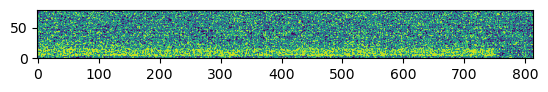

Epoch 5, Model Loss: 0.1657191890217092, Duration Loss: 175.33896815167728


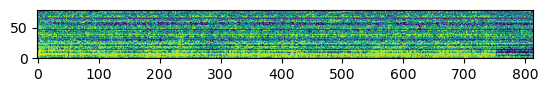

Epoch 10, Model Loss: 0.1594528584149632, Duration Loss: 12.076577538121352


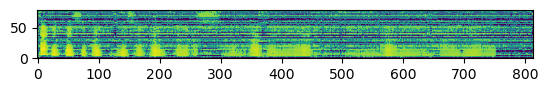

Epoch 15, Model Loss: 0.15529985954291628, Duration Loss: 4.488216593317741


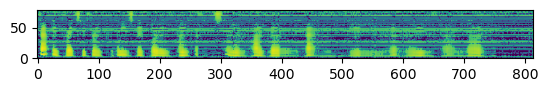

Epoch 20, Model Loss: 0.14962302191849175, Duration Loss: 3.675789578987734


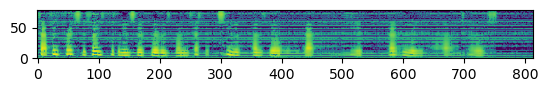

Epoch 25, Model Loss: 0.14174649946010898, Duration Loss: 3.2933809383072106


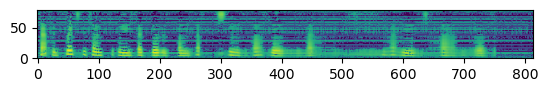

Epoch 30, Model Loss: 0.13433334497857274, Duration Loss: 3.407757591157064


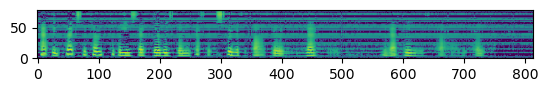

Epoch 35, Model Loss: 0.12467301419399077, Duration Loss: 3.7826931319967687


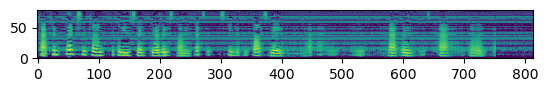

Epoch 40, Model Loss: 0.11640379882424412, Duration Loss: 4.146528317980524


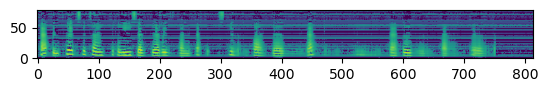

Epoch 45, Model Loss: 0.10954684220308812, Duration Loss: 3.8008041199106364


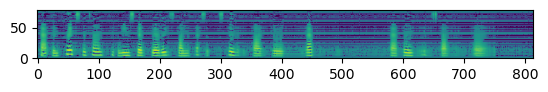

Epoch 50, Model Loss: 0.10349074326945047, Duration Loss: 3.504806509853278


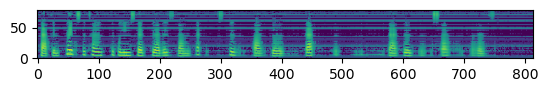

Epoch 55, Model Loss: 0.09881280302783864, Duration Loss: 3.3793038973843106


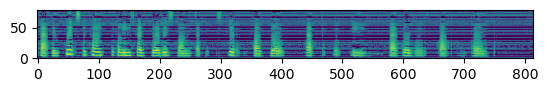

Epoch 60, Model Loss: 0.09433105495506831, Duration Loss: 2.9213489276649307


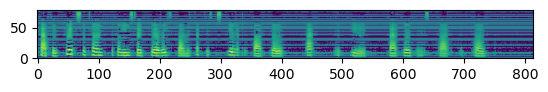

Epoch 65, Model Loss: 0.09060967632018739, Duration Loss: 2.8189388409148166


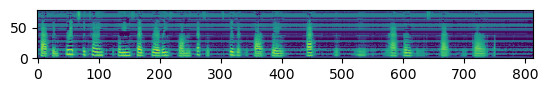

Epoch 70, Model Loss: 0.08733490278033447, Duration Loss: 2.6221695181227087


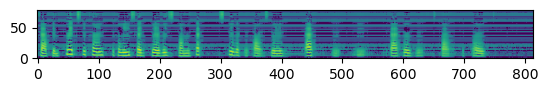

Epoch 75, Model Loss: 0.08437333816159383, Duration Loss: 2.453203553265899


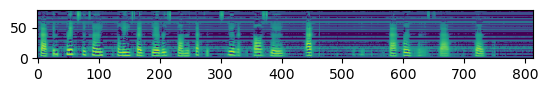

Epoch 80, Model Loss: 0.08154762694000327, Duration Loss: 2.409729393294258


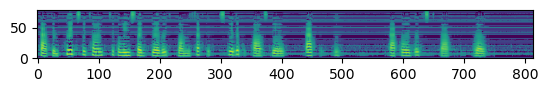

Epoch 85, Model Loss: 0.07928496506744927, Duration Loss: 2.327937452897538


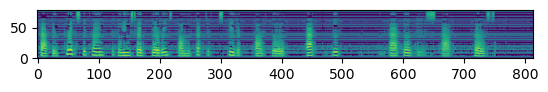

Epoch 90, Model Loss: 0.07713052119216779, Duration Loss: 2.402562975883483


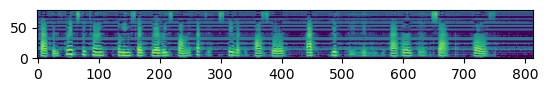

Epoch 95, Model Loss: 0.07504534454893894, Duration Loss: 2.2867138015962882


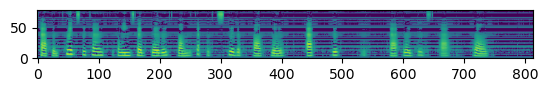

Epoch 100, Model Loss: 0.07334304726036797, Duration Loss: 2.06486608925527


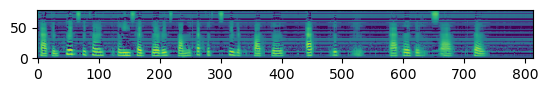

Epoch 105, Model Loss: 0.0716517107547635, Duration Loss: 2.0692041194351924


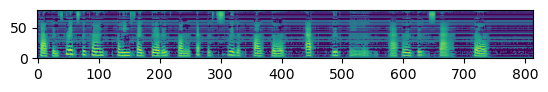

Epoch 110, Model Loss: 0.07022080173457627, Duration Loss: 1.880729572181283


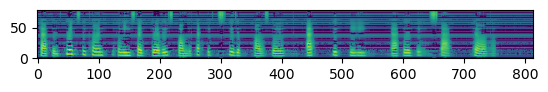

Epoch 115, Model Loss: 0.06865707735945711, Duration Loss: 1.8719421842672528


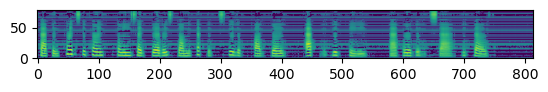

Epoch 120, Model Loss: 0.06741711494587636, Duration Loss: 1.7293393411775584


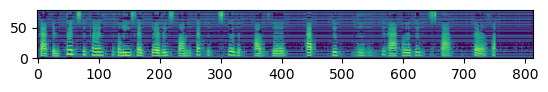

Epoch 125, Model Loss: 0.06619284726189871, Duration Loss: 1.6876711240650095


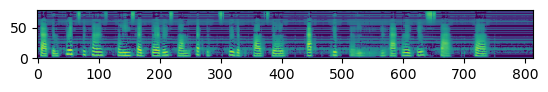

Epoch 130, Model Loss: 0.06508316325336476, Duration Loss: 1.800222057060604


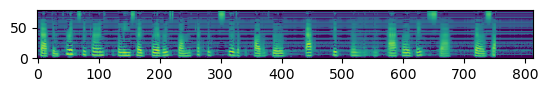

Epoch 135, Model Loss: 0.06403931828528424, Duration Loss: 1.6422177107229723


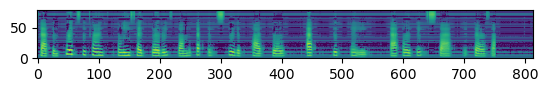

Epoch 140, Model Loss: 0.0631431740348356, Duration Loss: 1.7036010760025388


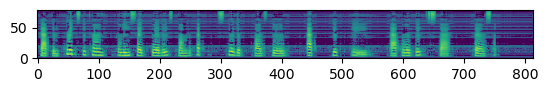

Epoch 145, Model Loss: 0.06218481311289062, Duration Loss: 1.7232631958314097


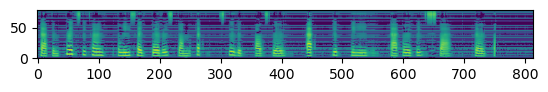

Epoch 150, Model Loss: 0.061254297131604525, Duration Loss: 1.5541518108688135


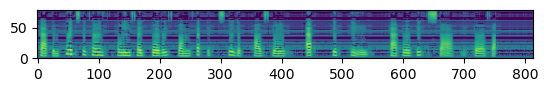

Epoch 155, Model Loss: 0.060431900740104856, Duration Loss: 1.455160534512387


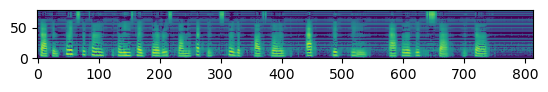

Epoch 160, Model Loss: 0.059691619916553904, Duration Loss: 1.5183672941949242


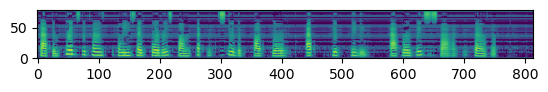

Epoch 165, Model Loss: 0.05893293099246753, Duration Loss: 1.5845622955447565


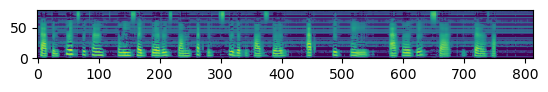

Epoch 170, Model Loss: 0.05825868379460634, Duration Loss: 1.4535104082013568


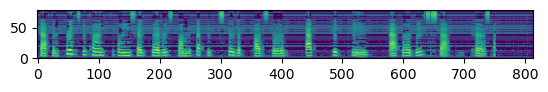

Epoch 175, Model Loss: 0.05755866835587214, Duration Loss: 1.5052563178278233


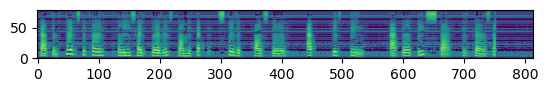

Epoch 180, Model Loss: 0.05700492124705419, Duration Loss: 1.441491642137514


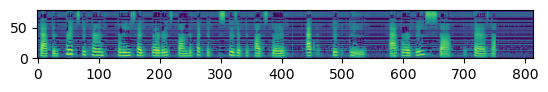

Epoch 185, Model Loss: 0.056221115600018585, Duration Loss: 1.3676112385561867


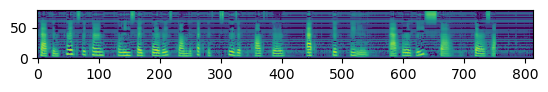

Epoch 190, Model Loss: 0.05578897890709612, Duration Loss: 1.3560328368287893


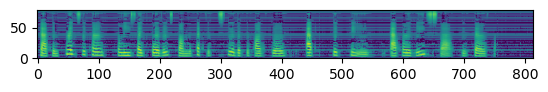

Epoch 195, Model Loss: 0.05529144490613555, Duration Loss: 1.3824988301217986


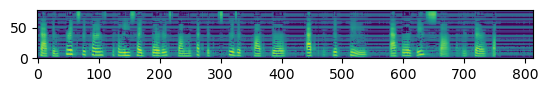

Epoch 200, Model Loss: 0.054717069750067085, Duration Loss: 1.3879121496294542


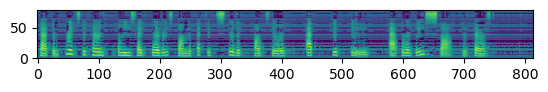

Epoch 205, Model Loss: 0.05424273144589724, Duration Loss: 1.302778796340427


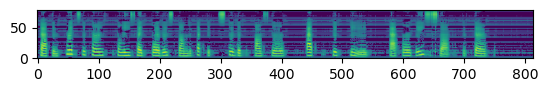

Epoch 210, Model Loss: 0.053679068321294154, Duration Loss: 1.2548682235018185


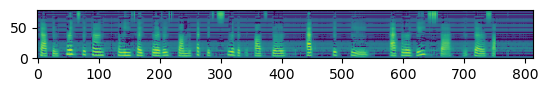

Epoch 215, Model Loss: 0.053235882417346475, Duration Loss: 1.2488940240692916


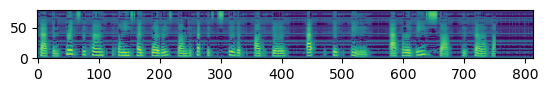

Epoch 220, Model Loss: 0.05279448981920295, Duration Loss: 1.3386415987119187


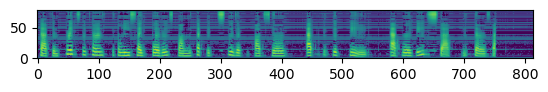

Epoch 225, Model Loss: 0.052426489246805215, Duration Loss: 1.299989416216412


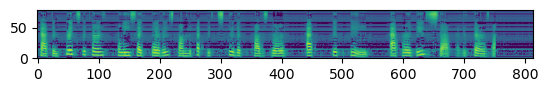

Epoch 230, Model Loss: 0.05199657211991124, Duration Loss: 1.3365792747396616


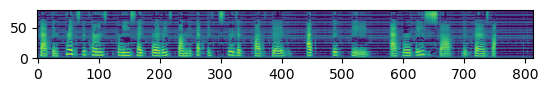

Epoch 235, Model Loss: 0.0515505242141059, Duration Loss: 1.2648844061976805


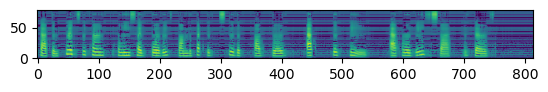

Epoch 240, Model Loss: 0.05119851427356691, Duration Loss: 1.2529436302011028


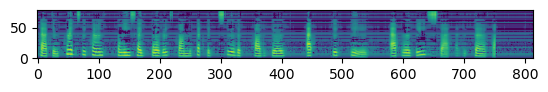

Epoch 245, Model Loss: 0.05087746059807546, Duration Loss: 1.234641831286632


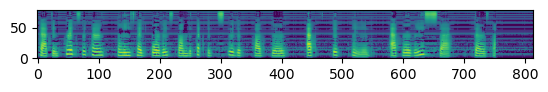

Epoch 250, Model Loss: 0.050411276519298547, Duration Loss: 1.2206105637724385


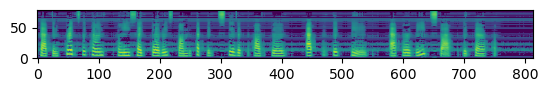

Epoch 255, Model Loss: 0.0501628223344357, Duration Loss: 1.2101336130260547


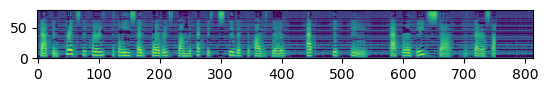

Epoch 260, Model Loss: 0.049777752074011916, Duration Loss: 1.1568098925325987


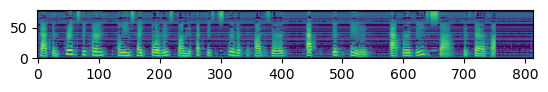

Epoch 265, Model Loss: 0.04948958411921553, Duration Loss: 1.1770543614878275


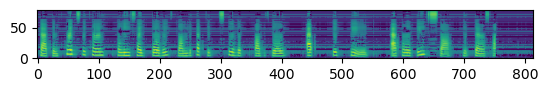

Epoch 270, Model Loss: 0.049150074458252785, Duration Loss: 1.1942789400145954


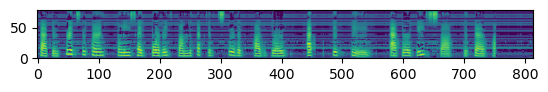

Epoch 275, Model Loss: 0.04891337533175512, Duration Loss: 1.2093718950330765


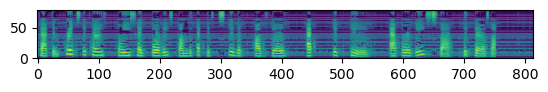

Epoch 280, Model Loss: 0.04858121683780295, Duration Loss: 1.1969268580857857


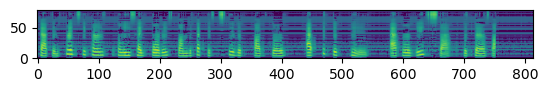

Epoch 285, Model Loss: 0.04826315979126596, Duration Loss: 1.0999866932848075


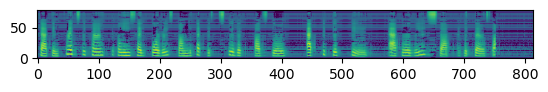

Epoch 290, Model Loss: 0.04800165371194374, Duration Loss: 1.0978388688425078


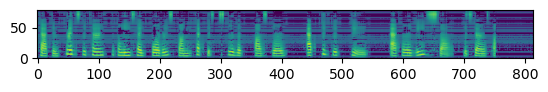

Epoch 295, Model Loss: 0.04769431035557802, Duration Loss: 1.1417562820180496


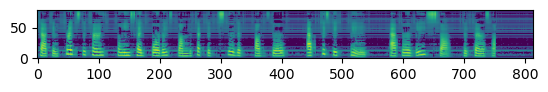

Epoch 300, Model Loss: 0.04745476828874462, Duration Loss: 1.1131424264316139


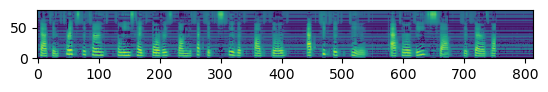

Epoch 305, Model Loss: 0.04716523859078868, Duration Loss: 1.1043455246156149


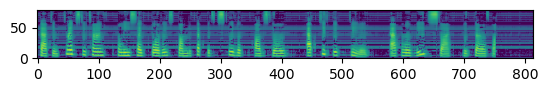

Epoch 310, Model Loss: 0.04694164033136232, Duration Loss: 1.0766011315540682


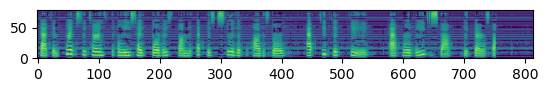

Epoch 315, Model Loss: 0.04665822628205708, Duration Loss: 1.1351002030564048


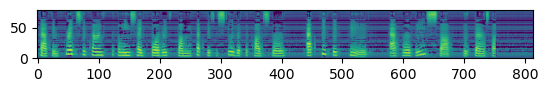

Epoch 320, Model Loss: 0.04640708143149852, Duration Loss: 1.0832503907871944


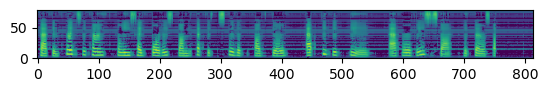

Epoch 325, Model Loss: 0.046120854624866585, Duration Loss: 1.0674990500411843


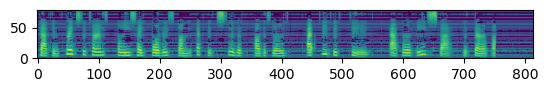

Epoch 330, Model Loss: 0.04603286052163501, Duration Loss: 1.0330614464996506


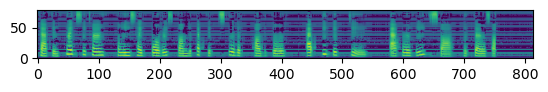

Epoch 335, Model Loss: 0.04579556918274747, Duration Loss: 0.9758623505595825


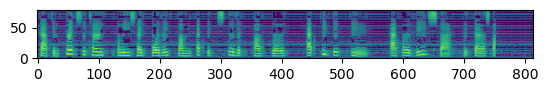

Epoch 340, Model Loss: 0.04552419306914303, Duration Loss: 1.0200964342938723


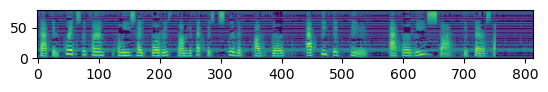

Epoch 345, Model Loss: 0.045394455483795094, Duration Loss: 0.9789892335007659


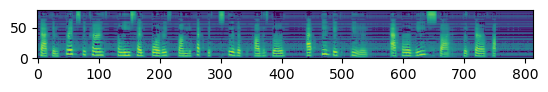

Epoch 350, Model Loss: 0.04514385099067309, Duration Loss: 1.0323573490128897


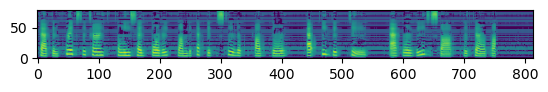

Epoch 355, Model Loss: 0.0449851196612755, Duration Loss: 1.0500905276650059


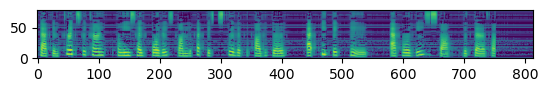

Epoch 360, Model Loss: 0.044732234556309515, Duration Loss: 0.9486366036164506


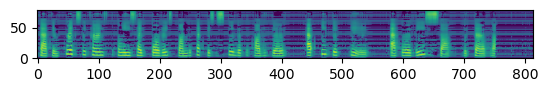

Epoch 365, Model Loss: 0.04458321266583281, Duration Loss: 0.980619914775347


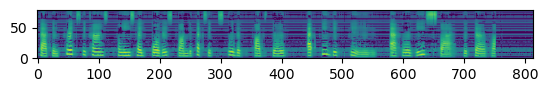

Epoch 370, Model Loss: 0.04435890820557182, Duration Loss: 0.9727000122087723


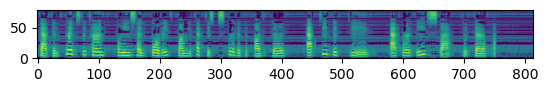

In [ ]:
from torch.cuda.amp import autocast, GradScaler

model_num = 0
loss_tracking = []
loss_tracking_d = []

for i in tqdm(range(epochs)):
    running_loss = 0
    running_loss_d = 0
    for idx, data in enumerate(dl):
        mels, phones, durations = map(lambda x: x.to(device), data)
        optimizer.zero_grad()

        pred, pred_durations = model(phones, durations, upsample_ratio, True)
#         mel_len = durations[:, :-1].sum(1)
        
#         loss_m = sum([loss_fn_m(pred[i,:,:mel_len[i]], mels[i,:,:mel_len[i]])
#                       for i in range(mel_len.size(0))]) / mel_len.size(0)
        loss_m = loss_fn_m(pred, mels)
        loss_d = loss_fn_v(pred_durations[:,:-1], torch.log(durations[:,:-1] + 1e-20))

        loss_m.backward()
        loss_d.backward()

        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        if (idx+1) % accum_grad == 0 or (idx+1) == len(dl):
            optimizer.step()
            scheduler.step()

        running_loss += loss_m.detach().item() / len(dl)
        running_loss_d += loss_d.detach().item() / len(dl)

    loss_tracking.append(running_loss)
    loss_tracking_d.append(running_loss_d)

    if i % log_interval == 0:
        print(f"Epoch {i}, Model Loss: {running_loss}, Duration Loss: {running_loss_d}")
        with torch.no_grad(): out = model(phones_val[None, 0], durations_val[None, 0], 
                                         upsample_ratio).cpu()[0]
        plt.imshow(librosa.power_to_db(out.numpy()), origin="lower");
        plt.show()
        model_path = f"models/model_save_{model_num}.pt"
        torch.save(model.state_dict(), model_path)
        model_num += 1

In [ ]:
plt.plot(loss_tracking)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show();

In [ ]:
plt.plot(loss_tracking_d)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Duration")
plt.show();

In [ ]:
out = model(phones_val[None, 0], durations_val[None, 0], upsample_ratio).detach().cpu()

In [ ]:
plt.imshow(librosa.power_to_db(out[0].numpy()), origin="lower");

In [ ]:
plt.imshow(librosa.power_to_db(mels_val[0].cpu().numpy()), origin="lower");

In [ ]:
path_models = f"models/model_{model_num}.pt"
torch.save(model.state_dict(), path_models)
model_num += 1